# Report 1

This report should provide insights related to the employee emotional state and its evolution per industry they work with.

In [2]:
import numpy as np
import modin.pandas as pd
import gender_guesser.detector as gender
import warnings
import seaborn as sns
import matplotlib.pyplot as plt

from PsqlConn import create_psql_engine

In [3]:
%matplotlib inline
# Suppress warnings (for better notebook readability)
warnings.filterwarnings(action='ignore')

# Apply seaborn default settings
sns.set()

# Create engine for connection with DB
engine = create_psql_engine()

In [4]:
# Utility functions

# These could've been lambda functions, but the function name is used as the column name, so it's handier this way
def male_count(series:pd.Series):
    return sum(series == 'male')

def female_count(series:pd.Series):
    return sum(series == 'female')

def male_female_ratio(series:pd.Series):
    return sum(series == 'male')/sum(series == 'female')

def unknown_count(series:pd.Series):
    return sum(series == 'unknown')

____________________
## Population description
First let's take a look at our population and try to understand what's the distribution of users among companies, industries and ages.

In [5]:
# Query to fetch a simple user table with company and industry names
pop_q = f'''
-- Get users and their company and industry
select distinct u.id as userid,
                u.name as username,
                u.age as userage,
                cm.name as companyname,
                i.name as industryname
from users u 
left join companies cm
on(cast(u.companyid as text) = cm.id )
left join industries i 
on(i.id = cast(u.industryid as text) )
;
'''

pop_df = pd.read_sql_query(pop_q, engine)
pop_df.head()

,userid,username,userage,companyname,industryname
0,517a8deb-14d2-4662-8ca5-a2515bf06326,Aurelia,21,Apple,Marketing
1,b3152a96-6055-44f5-87fe-4d1763129bb9,Alisa,25,Pied Piper,Marketing
2,5c185183-ee83-426b-b535-8d9ba776c731,Chester,36,Twitter,Marketing
3,4a45d028-906e-4e42-b768-7071b48bc6e4,Zechariah,36,Pied Piper,Finance
4,d94ca93a-66f3-4972-a07d-c774109ba7d3,Ramona,29,Twitter,Sales


Straight away, one thing we can do to augment our data is to try to guess what is the gender of the user based on their name. We can infer that using a package such as https://pypi.org/project/gender-guesser/.

In [6]:
# Create a detector object
genderDetector = gender.Detector()

# We guess the the genders and then check what we got
pop_df['genderguess'] = pop_df.username.apply(lambda x: genderDetector.get_gender(x))

print(f"Out of {pop_df['userid'].nunique()} users, this was the proportion of genders guessed:")
display(pop_df['genderguess'].value_counts())

Out of 2000 users, this was the proportion of genders guessed:


female           883
male             831
unknown          147
mostly_male       62
mostly_female     51
andy              26
dtype: int64

With this we were able to guess around 86% as definitively either male of female. Some remarks:

* The `mostly_male` and `mostly_female` labels represent 3.1% and 2.6% of the population so we are going to join them with the `male` and `female` labels for simplicity.
* The `andy` label represents names that can be either male or female. This label represents 1.3% of our population. Since this is such a low value we are going to keep it as it's own thing instead of drilling down further.
* The `unknow` label represents names that the detector was unable to guess as either gender. They are 7.35% of our population, so it's also a small subset. The total number of distinct names is 116. Since the gender is just a guess, there is no point in trying to fit the these into either of the male or female labels.

In [7]:
# Replace the `mostly_xxx`labels with the definitive ones
gender_simpl_dict = {"mostly_male":'male',
                    "mostly_female": 'female',
                    }
pop_df["genderguess"]=pop_df["genderguess"].replace(gender_simpl_dict)

# Save categories as factor to save memory
pop_df["genderguess"]=pop_df["genderguess"].astype('category')

In [8]:
# Lets check how many users we have per company, industry and company + industry
print("Number of unique users per company")
display(pop_df.groupby("companyname")["userid"].nunique())

print("\nNumber of unique users per industry")
display(pop_df.groupby("industryname")["userid"].nunique())

Number of unique users per company


companyname
Apple         682
Facebook      333
Pied Piper    320
Twitter       665
Name: userid, dtype: int64


Number of unique users per industry


industryname
Finance      313
Marketing    676
Sales        371
Tech         640
Name: userid, dtype: int64

In [9]:
# Let's get a distribution of the user age and gender per company + industry pair
print(f'''Overview of user's features per gender and company:''')
display(
    pop_df.groupby(["companyname", "industryname"]).agg({'userid':'nunique',
                                                     'userage': [min, np.median, 'max', 'mean'], 
                                                     'genderguess': [male_count, female_count, male_female_ratio, unknown_count]
                                                    })
)

Overview of user's features per gender and company:


userid userage                       genderguess  \
                         nunique     min median max       mean  male_count   
companyname industryname                                                     
Apple       Finance           96      18   27.0  40  27.208333          43   
            Marketing        242      18   25.5  41  26.475207         110   
            Sales            131      18   25.0  39  25.900763          57   
            Tech             213      18   25.0  41  26.309859          94   
Facebook    Finance           53      18   27.0  41  26.981132          24   
            Marketing        116      18   27.0  41  27.129310          60   
            Sales             47      18   29.0  41  28.851064          15   
            Tech             117      18   27.0  41  27.350427          48   
Pied Piper  Finance           47      18   24.0  40  26.191489          24   
            Marketing        110      18   25.0  40  26.054545          40   
            Sales             64      18   26.0  41  26.031250          32   
            Tech              99      18   27.0  41  26.969697          42   
Twitter     Finance          117      18   27.0  40  27.324786          51   
            Marketing        208      18   28.0  40  27.259615         101   
            Sales            129      18   29.0  41  28.263566          62   
            Tech             211      18   28.0  41  27.189573          90   

                                                                       
                         female_count male_female_ratio unknown_count  
companyname industryname                                               
Apple       Finance                47          0.914894             5  
            Marketing             112          0.982143            15  
            Sales                  65          0.876923             6  
            Tech                  102          0.921569            16  
Facebook    Finance                23          1.043478             4  
            Marketing              44          1.363636            11  
            Sales                  27          0.555556             5  
            Tech                   57          0.842105             9  
Pied Piper  Finance                21          1.142857             1  
            Marketing              61          0.655738             7  
            Sales                  23          1.391304             9  
            Tech                   51          0.823529             4  
Twitter     Finance                55          0.927273            11  
            Marketing              83          1.216867            20  
            Sales                  58          1.068966             9  
            Tech                  105          0.857143            15

In the above table we can see that the groups we get by splitting the users per company and industry are very similar when it comes to age and gender. 

* The min age registered for each group is 18 years for all groups.
* The max age is either 40 or 41, with one exception (39)
* The median age is always between 24 and 29 years old, while the mean is within the interval (26; 29) years old.
* When it comes to `guessedgender` the ratio between male and female is also very similar among the different groups, and usually close to 1.

_______________
## Emotional state

To get this information, we will need the moodtracker table. 

We could do the necessary joins in SQL, but since the tables are small and we already added the gender column to our `pop_df`, the join will be done on this notebook.

In [10]:
# Get the moodtracker table
moodtracker_df = pd.read_sql_table('moodtracker', engine)
moodtracker_df.head()

,id,userid,trackedat,mood,reasonid
0,f0ed2548-dc73-45be-ac19-005331bfdd70,05733a01-7fda-4295-8ca4-1962ec5df898,2020-01-09 02:55:06,ok,57d9dc1ee66d040ed4e496a9
1,5bc270e5-2293-4eb6-b760-e2ef9e44daa2,57ccba4e-8df5-4d6e-a791-e47311196f0f,2020-01-15 15:54:53,angry,57db1d11e66d090e6410b868
2,394fb904-8c96-45e2-836e-2efdaa167c1a,5706369b-f2e5-4960-a45f-4aa22161fa3b,2020-01-22 01:39:22,angry,5c6c2a2a9c79eca733d4dd23
3,c5ede79a-f474-4a96-a6b4-0ec8119d9f73,e0be2515-b159-4dcb-9e50-85de5acefe6b,2020-01-31 12:52:46,happy,57d9dc21e66d040ed4e496c7
4,fa45550d-6a9c-4e8e-90e6-d73cc7202179,908138a6-fc5b-42cf-8cd4-0ac5ce0bdb1c,2020-01-09 19:50:06,ok,5c6c2a229c79eca733d4dd16


Let's check if all our userid in the moodtracker table are also in our `pop_df`

In [11]:
# Find how many userid may be missing from either one of the tables
missing_f_moodtracker = set(moodtracker_df.userid) - set(pop_df.userid)
missing_f_pop = set(pop_df.userid)- set(moodtracker_df.userid)

print(f'There are {len(missing_f_moodtracker)} userid in moodtracker_df not found in pop_df and {len(missing_f_pop)} userid in pop_df not found in moodtracker_df')

There are 0 userid in moodtracker_df not found in pop_df and 0 userid in pop_df not found in moodtracker_df


We see that we have total overlap of users in both tables, so we can join them without the fear of getting an incomplete merged table.

Before that however, we are going to look into the moodtracker table by itself first.

In [12]:
print(f'Possible mood values and registered counts:')
display(moodtracker_df.mood.value_counts())

Possible mood values and registered counts:


angry          24577
super-happy    24577
happy          16545
ok             16371
sad            16273
                1657
dtype: int64

Given that we have 100k registers (rows) in the moodtracker table, we can see that around 1.65% of our registers have an empty value for the mood variable. At this point it is not clear wether this is due to incorrect data or the tool not being used, so we won't address it for now.

In [13]:
# Let's check how many times the moodtracker feature is used per day per user
moodtracker_df['trackedat_date'] = pd.to_datetime(moodtracker_df.trackedat).strftime('%Y-%m-%d')

In [14]:
# Let's plot the number of moodtracker registers per day
moodtracker_logs_day = moodtracker_df.trackedat_date.value_counts().sort_index().reset_index()
moodtracker_logs_day.columns = ['trackedat_date', 'total_day_registers']

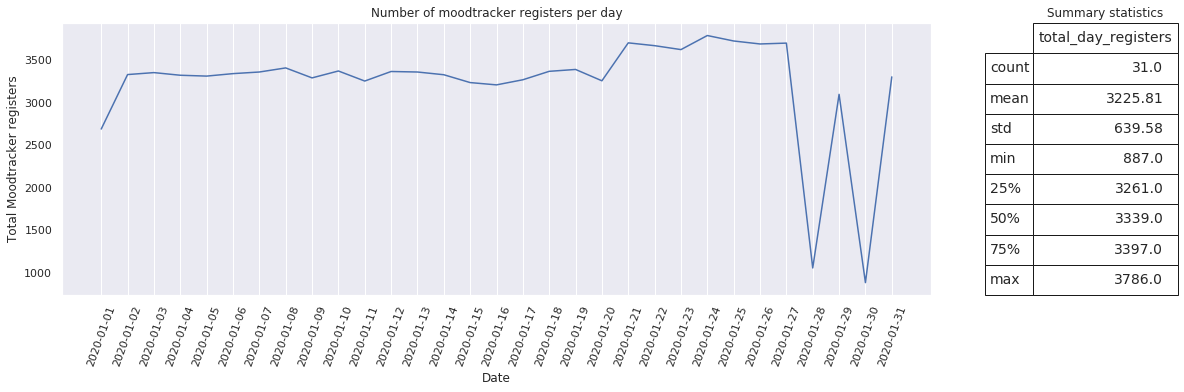

In [15]:
# Let's check some summary statistics on the number of moodtracker registers
f, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [6, 1]}, figsize=(20,5))

chart=sns.lineplot(x='trackedat_date', y='total_day_registers', 
                 markers=True,
                 data=moodtracker_logs_day, ax=ax1)

ax1.set_xlabel("Date")
ax1.set_ylabel("Total Moodtracker registers")
ax1.tick_params('x',labelrotation=70)
ax1.set_title("Number of moodtracker registers per day")
chart.yaxis.grid(False)

font_size=14
bbox=[0, 0, 1, 1]
ax2.axis('off')
ax2.set_title("Summary statistics")
mpl_table = ax2.table(cellText = moodtracker_logs_day.describe().round(2).values, 
                      rowLabels = moodtracker_logs_day.describe().index, 
                      bbox=bbox, 
                      colLabels=moodtracker_logs_day.describe().columns)
mpl_table.auto_set_font_size(False)
mpl_table.set_fontsize(font_size)

We can see in the plot above that the number of registers on the moodtracker table until 2020-01-22, where we can see an increase to a new level, that is sustained until 2020-01-27. During this interval the values are very consistent, as we can see by how tight the percentile range is, since the values for the 25%, 50% and 75% percentiles are very close to each other.

Following this we see a sharp dip on 2020-01-28, followed by a small increase the following day and another dip to the minimum value registered of 887, followed by another increase on the last day of the month.

In [35]:
# Let's compute how many mood values each user registers per day
daily_mood_user = moodtracker_df.groupby(["trackedat_date", "userid"]).agg({"trackedat" : "nunique",
                                                          "mood": ["unique", 'nunique'],
                                                         })
# Flatten multiindex table
daily_mood_user = daily_mood_user.stack().reset_index().rename(columns = {"level_2":"applied_function"}).copy()

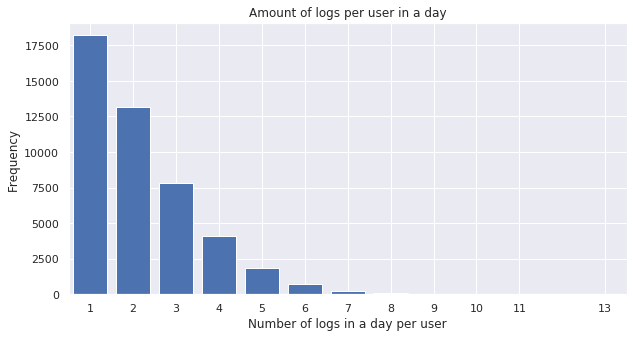

There are a total of 99996 logs.
The probability of a user using the tracker 5 or more times is 6.14%


In [142]:
# Count the number of distinct 
daily_mood_user_count = daily_mood_user.query("applied_function == 'nunique'").trackedat.value_counts().reset_index().copy()
daily_mood_user_count.columns = ["number_of_registers", "count"]

# Plot the frequency of the amount of logs per user daily
x = daily_mood_user_count["number_of_registers"]
height = daily_mood_user_count["count"]

fig = plt.figure(figsize=(10,5))
_ = plt.bar(x=x,
        height=height)

plt.xlim([x.min()-0.5,x.max()+0.5])
plt.title("Amount of logs per user in a day")
plt.xlabel("Number of logs in a day per user")
plt.ylabel("Frequency")
plt.xticks(x)
plt.show()

# Total of logs that were logged in a batch < 4 per day
sum((daily_mood_user_count["count"]*daily_mood_user_count["number_of_registers"]/99996*100)[0:3])

total_logs = round(sum(daily_mood_user_count["count"]*daily_mood_user_count["number_of_registers"]))
print(f'There are a total of {str(total_logs)} logs.')

prob_more_than5 = round(sum(daily_mood_user_count["count"][4:])/sum(daily_mood_user_count["count"])*100,2)
print(f"The probability of a user using the tracker 5 or more times is {prob_more_than5}%")

Like shown in the plot above, usually the vast majority of users tend to use the moodtracker between 1 to 3 times per day (this group represent around 68% of the registers in the table). We also see that there is a very low probability of a user using the moodtracker 5 or more times in the same day.

This plot raises 2 questions though:
* The total of logs computed from the plot is 99996 logs instead of the original 100000. What happened to the missing 4?
* This plot does not show the amount of different moods logged throughout the day. What if a user logs more than 1 mood per day?

In [152]:
# Since we grouped the data by userid and date and counted the distinct timestamps to get the number of logs
# we should check if there are duplicate pair of userid/trackedat timestamps

print(f'There are {sum(moodtracker_df.duplicated(["userid", "trackedat"]))} duplicate userid/timestamp pairs.')
print("Duplicate entries:")
display(moodtracker_df[moodtracker_df.duplicated(["userid", "trackedat"], keep = False)].sort_values("trackedat"))

There are 4 duplicate userid/timestamp pairs.
Duplicate entries:


,id,userid,trackedat,mood,reasonid,trackedat_date
18911,1c694811-e7fb-4fb4-80f0-ee8ec095d19a,5503d473-aa7c-47fa-93ae-e000d54d2531,2020-01-02 18:52:29,angry,58335abb514129a045865b08,2020-01-02
61396,824d5ca9-5fad-44e6-a907-be2515df0766,5503d473-aa7c-47fa-93ae-e000d54d2531,2020-01-02 18:52:29,happy,5c6c293f9c79eca733d4dd0b,2020-01-02
16280,26e281f2-092d-45e6-839d-875d1716e4cf,833800cf-b9d2-4e95-89db-5a1d17c97dc7,2020-01-10 18:51:52,angry,5c6c2a259c79eca733d4dd1b,2020-01-10
27059,64bbf981-f851-412c-9942-e76d5ab77e40,833800cf-b9d2-4e95-89db-5a1d17c97dc7,2020-01-10 18:51:52,ok,57d9dc1ee66d040ed4e496a9,2020-01-10
55622,d51138fc-8c8e-4a38-b2bc-db89a2da8bf9,a7ccfd35-58fa-484e-aeee-f1d9e6167d6e,2020-01-10 22:14:49,super-happy,57d9dc1de66d040ed4e4969e,2020-01-10
78862,f153221c-b54f-4eef-ad91-d60ce7f49f1f,a7ccfd35-58fa-484e-aeee-f1d9e6167d6e,2020-01-10 22:14:49,super-happy,5b0d5ce1abb35bed38c2ce52,2020-01-10
18418,6c56ea16-a95f-45c5-ae8f-4e8c856efc86,14050378-d393-4821-9291-cce422f981e6,2020-01-21 18:13:41,super-happy,57d9dc1de66d040ed4e4969e,2020-01-21
43383,71b1a22c-c51a-4659-ad4a-f46f6b44f3a3,14050378-d393-4821-9291-cce422f981e6,2020-01-21 18:13:41,happy,58335abb514129a045865b08,2020-01-21


We now know where the 4 missing entries are. We can see that there are entries with the same userid and timestamp, but with they are either duplicates or have different moods. Since there are only 4 instances of this out of 100k rows in the table, we are not fixing it for the scope of this report.

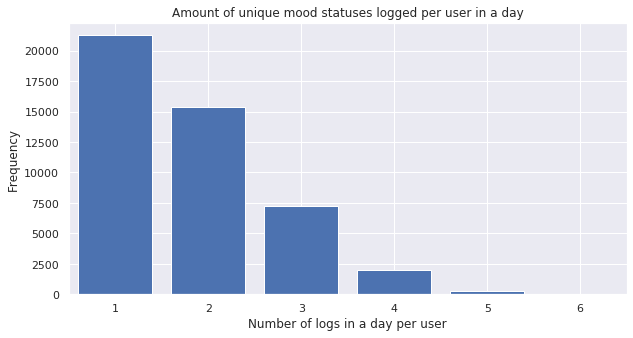

There are a total of 82994 logs.
The probability of a user registering 3 or more distinct moods is 20.65%


In [167]:
# Count the number of distinct 
daily_mood_mood_count = daily_mood_user.query("applied_function == 'nunique'").mood.value_counts().reset_index().copy()
daily_mood_mood_count.columns = ["number_of_mood", "count"]

# Plot the frequency of the amount of logs per user daily
x = daily_mood_mood_count["number_of_mood"]
height = daily_mood_mood_count["count"]

fig = plt.figure(figsize=(10,5))
_ = plt.bar(x=x,
        height= height)

plt.xlim([x.min()-0.5,x.max()+0.5])
plt.title("Amount of unique mood statuses logged per user in a day")
plt.xlabel("Number of logs in a day per user")
plt.ylabel("Frequency")
plt.xticks(x)
plt.show()

# Total of logs that were logged in a batch < 4 per day
sum((daily_mood_mood_count["count"]*daily_mood_mood_count["number_of_mood"]/99996*100)[0:3])

total_logs = round(sum(daily_mood_mood_count["count"]*daily_mood_mood_count["number_of_mood"]))
print(f'There are a total of {str(total_logs)} logs.')

prob_more_than = round(sum(daily_mood_mood_count["count"][2:])/sum(daily_mood_mood_count["count"])*100,2)
print(f"The probability of a user registering 3 or more distinct moods is {prob_more_than}%")

Similar to what've seen before, most of the users log 1 or 2 different kinds of mood in a given day. We can see that only 1 in 4 people register 3 or more **distinct** mood statuses in a day. It's important to make this distinction, since it will be crucial in how we go about analysing the mood of the users over time.

Like before, we have inconsistent number of logs, 82994 vs 100000. We aggregated our data by userid and date. If in the same day, the same user logged the same mood more than once, we are only counting it once (hence the importance of being explicit about **distinct** mood values). 

In [165]:
# Let's check for duplicated moods logged in the same day

print(f'There are {sum(moodtracker_df.duplicated(["userid", "trackedat_date", "mood"]))} duplicate userid/date/mood tuples.')

There are 17006 duplicate userid/date/mood tuples.


This number lines up perfectly with the 82944 value computed before, since they add up to the total number of 100000 registers.

Now that we have some insights regarding the use of the moodtracker, we can start to think about how to connect the information on `moodtracker_df` with the one of the population.

_______________
## Population + Moodtracker

Our target variable is **mood**. This is a categorical variable, meaning that we can't simply compute it's average value for each day, since all we have are strings. There are 2 strategies that we are going to follow in parallel.

* Since we have some insight on the moodtracker data, we can transform our table to make our life easier while still using the data correctly. Here's what we know:
    * Most users don't use the moodtracker feature more than 2~3 times per day.
    * 80% of the users log either 1 or 2 distinct moods in a day.
    * 

In [216]:
# Let's check the evolution of each mood along time

moodtracker_df.groupby(["trackedat_date", "mood"])["userid"].count().reset_index()

,trackedat_date,mood,userid
0,2020-01-01,,37
1,2020-01-01,angry,653
2,2020-01-01,happy,462
3,2020-01-01,ok,419
4,2020-01-01,sad,461
...,...,...,...
181,2020-01-31,angry,783
182,2020-01-31,happy,536
183,2020-01-31,ok,563
184,2020-01-31,sad,556
